In [1]:
%pylab inline
from astropy.io import fits
import glob
import pandas as pd
from pandas import DataFrame
from scipy.interpolate import interp1d
#from nirspec import gluespec,divspec
import pdb as pdb
import astropy
from astropy import units as u
from astroquery.hitran import Hitran
from flux_calculator import extract_hitran_data, calc_fluxes, extract_vup, make_rotation_diagram
import numpy as np
import pdb as pdb
from astropy.io import fits
from astropy.table import Table
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
def divspec(datadir, srcfile, stdfile, dtau=0, dpix=0, mode=None,plot=True):
    #Read in data for source and standard
    hdulist_src=fits.open(datadir+srcfile)
    data_src=hdulist_src[1].data
    hdr_src=hdulist_src[0].header
    hdulist_std=fits.open(datadir+stdfile)
    data_std=hdulist_std[1].data

    pwave_src=data_src['wave_pos']
    nwave_src=data_src['wave_neg']
    pwave_std=data_std['wave_pos']
    nwave_std=data_std['wave_neg']
    
    #Correcting for H Emission Line at 4.655 wavelength-need to go back in to fix this a little better. Is this something I can use HITRAN for?
    list_length = 1024 
    low = 4.65
    high = 4.66
    corrected_data = np.zeros(list_length)

    #pflux H avoidance in median calculation
    for m in range(list_length):
        wave_data = np.array(pwave_src)
        flux_data = np.array(data_src['flux_pos'])
        if ((wave_data[m] < low) or (high < wave_data[m])):
            corrected_data[m] = flux_data[m] + 1 
        else :
            corrected_data[m] = None
    corrected_median_pflux_src = np.nanmedian(corrected_data)
  
    #nflux H avoidance
    corrected_data = np.zeros(list_length)
    for m in range(list_length):
        wave_data = np.array(nwave_src)
        flux_data = np.array(data_src['flux_neg'])
        if ((wave_data[m] < low) or (high < wave_data[m])):
            corrected_data[m] = flux_data[m] + 1 
        else :
            corrected_data[m] = None
    corrected_median_nflux_src = np.nanmedian(corrected_data)


    #Normalize spectra
    pflux_src=data_src['flux_pos']/corrected_median_pflux_src
    nflux_src=data_src['flux_neg']/corrected_median_nflux_src
    pflux_std=data_std['flux_pos']/np.median(data_std['flux_pos'])
    nflux_std=data_std['flux_neg']/np.median(data_std['flux_neg'])


    #If desired, do airmass correction of standard
    np.seterr(invalid='ignore')
    pflux_std=np.exp((1+dtau)*np.log(pflux_std))
    nflux_std=np.exp((1+dtau)*np.log(nflux_std))

    #If desired, do wavelength shift of standard
    dwave=(pwave_src[1]-pwave_src[0])*dpix    #Convert pixel shift to wavelength shift
    pwave_std=pwave_std+dwave
    nwave_std=nwave_std+dwave

    #Interpolate everything onto positive src wavelengths
    nf_src=interp1d(nwave_src,nflux_src,bounds_error=False)
    pf_std=interp1d(pwave_std,pflux_std,bounds_error=False)
    nf_std=interp1d(nwave_std,nflux_std,bounds_error=False)

    nflux_src=nf_src(pwave_src)
    pflux_std=pf_std(pwave_src)
    nflux_std=nf_std(pwave_src)

    #Divide source by standard
    pdiv=pflux_src/pflux_std
    ndiv=nflux_src/nflux_std

    #Combine positive and negative beams
    divflux=(pdiv+ndiv)/2.
    srcflux=(pflux_src+nflux_src)/2.
    stdflux=(pflux_std+nflux_std)/2.

    #Compute SNR's in desired regions
    if(mode is not None):
        if(mode=='M0'):
            xsnr1_left=4.66
            xsnr1_right=4.67
            xsnr2_left=4.685
            xsnr2_right=4.69
            xsnr3_left=4.70
            xsnr3_right=4.715
        if(mode=='M1'):
            xsnr1_left=4.73
            xsnr1_right=4.75
            xsnr2_left=4.75
            xsnr2_right=4.77
            xsnr3_left=4.77
            xsnr3_right=4.79
        if(mode=='M2'):
            xsnr1_left=4.965
            xsnr1_right=4.975
            xsnr2_left=4.985
            xsnr2_right=5.0
            xsnr3_left=5.01
            xsnr3_right=5.015
        if(mode=='M3'):
            xsnr1_left=5.04
            xsnr1_right=5.05
            xsnr2_left=5.065
            xsnr2_right=5.075
            xsnr3_left=5.09
            xsnr3_right=5.095
        w1=((pwave_src > xsnr1_left) & (pwave_src<xsnr1_right))
        w2=((pwave_src > xsnr2_left) & (pwave_src<xsnr2_right))
        w3=((pwave_src > xsnr3_left) & (pwave_src<xsnr3_right))
    else:
        w1=np.isfinite(srcflux)
        w2=w1
        w3=w1
                
    snr1=np.nanmean(divflux[w1])/np.nanstd(divflux[w1])
    snr2=np.nanmean(divflux[w2])/np.nanstd(divflux[w2])
    snr3=np.nanmean(divflux[w3])/np.nanstd(divflux[w3])
    print('SNR:', snr1,snr2,snr3)

    #Create columns
    c1  = fits.Column(name='wave', format='D', array=pwave_src)
    c2  = fits.Column(name='div', format='D', array=divflux)
    c3  = fits.Column(name='src', format='D', array=srcflux)
    c4  = fits.Column(name='std', format='D', array=stdflux)
    coldefs = fits.ColDefs([c1,c2,c3,c4])
    tbhdu = fits.BinTableHDU.from_columns(coldefs)
    primary_hdu = fits.PrimaryHDU(header=hdr_src)    
    hdul = fits.HDUList([primary_hdu, tbhdu])

   #Create output file name
    srcname=srcfile.split('_')[0]
    date=srcfile.split('_')[1]
    stdname=stdfile.split('_')[0]
    srcnum=srcfile.split('_')[2]
    if(mode is not None): 
        outfile=srcname+'_'+stdname+'_'+date+'_'+srcnum+'_'+mode+'_div.fits'
    else:
        outfile=srcname+'_'+stdname+'_'+date+'_'+srcnum+'_div.fits'

    #Write to fits file    
    hdul.writeto(outfile,overwrite=True) 
    print('Writing to: ', outfile)

    #Create astropy table
    spectrum_table = Table([pwave_src, divflux, srcflux, stdflux], names=('wave', 'div', 'src','std'),  dtype=('f8', 'f8','f8','f8'))
    spectrum_table['wave'].unit = 'micron'
    if(plot==True):
        fig=plt.figure(figsize=(14,6))
        ax1=fig.add_subplot(211)
        ax1.plot(spectrum_table['wave'],spectrum_table['src'],label='src')
        ax1.plot(spectrum_table['wave'],spectrum_table['std'],label='std')
        ax1.legend()

        ax2=fig.add_subplot(212)
        ax2.plot(spectrum_table['wave'],spectrum_table['div'],label='div')
        ax2.set_ylim(0.8,1.2)
        ax2.legend()

        if(mode is not None):
            ax1.axvline(xsnr1_left,linestyle='--',color='C2')
            ax1.axvline(xsnr1_right,linestyle='--',color='C2')
            ax1.axvline(xsnr2_left,linestyle='--',color='C2')
            ax1.axvline(xsnr2_right,linestyle='--',color='C2')
            ax1.axvline(xsnr3_left,linestyle='--',color='C2')
            ax1.axvline(xsnr3_right,linestyle='--',color='C2')
            ax2.axvline(xsnr1_left,linestyle='--',color='C2')
            ax2.axvline(xsnr1_right,linestyle='--',color='C2')
            ax2.axvline(xsnr2_left,linestyle='--',color='C2')
            ax2.axvline(xsnr2_right,linestyle='--',color='C2')
            ax2.axvline(xsnr3_left,linestyle='--',color='C2')
            ax2.axvline(xsnr3_right,linestyle='--',color='C2')
        plt.show()

    return spectrum_table

In [3]:
def gluespec(datadir, filelist):
    mode=[]
    date=[]
    src=[]
    for myfile in filelist:
        src.append(myfile.split('_')[0])
        date.append(myfile.split('_')[2])
        mode.append(myfile.split('_')[4])
    outfile=src[0]+'_'+date[0]+'_'+'glue.fits'
    m0bool=(np.array(mode)=='M0')
    m1bool=(np.array(mode)=='M1')
    m2bool=(np.array(mode)=='M2')
    m3bool=(np.array(mode)=='M3')
    m0files=[]
    m1files=[]
    m2files=[]
    m3files=[]
    if(m0bool.any()):
        m0files=np.array(filelist)[m0bool]
        for i,myfile in enumerate(m0files):
            m0file=datadir+myfile
            hdulist=fits.open(m0file)
            data=hdulist[1].data
            wave=data['wave']
            div=data['div'] + 0.076
            std=data['std']
            if(i==0): 
                wave0_m0=wave
                std_m0=std
                div_all_m0=div
            else:
                f=interp1d(wave,div)
                div_interp=f(wave0_m0)
                div_all_m0=div_all_m0+div_interp
        div_all_m0=div_all_m0/np.size(m0files)
    else:
        div_all_m0=np.array([])
        wave0_m0=np.array([])
        std_m0=np.array([])
        
    if(m1bool.any()):
        m1files=np.array(filelist)[m1bool]
        for i,myfile in enumerate(m1files):
            m1file=datadir+myfile
            hdulist=fits.open(m1file)
            data=hdulist[1].data
            wave=data['wave']
            div=data['div']
            std=data['std']
            if(i==0): 
                wave0_m1=wave
                div_all_m1=div
                std_m1=std
            else:
                f=interp1d(wave,div)
                div_interp=f(wave0_m1)
                div_all_m1=div_all_m1+div_interp
        div_all_m1=div_all_m1/np.size(m1files)
    else:
        div_all_m1=np.array([])
        wave0_m1=np.array([])
        std_m1=np.array([])

    if(m2bool.any()):
        m2files=np.array(filelist)[m2bool]
        for i,myfile in enumerate(m2files):
            m2file=datadir+myfile
            hdulist=fits.open(m2file)
            data=hdulist[1].data
            wave=data['wave']
            div=data['div']
            std=data['std']
            if(i==0): 
                wave0_m2=wave
                div_all_m2=div
                std_m2=std
            else:
                f=interp1d(wave,div)
                div_interp=f(wave0_m2)
                div_all_m2=div_all_m2+div_interp
        div_all_m2=div_all_m2/np.size(m2files)
    else:
        div_all_m2=np.array([])
        wave0_m2=np.array([])
        std_m2=np.array([])

    if(m3bool.any()):
        m3files=np.array(filelist)[m3bool]
        for i,myfile in enumerate(m3files):
            m3file=datadir+myfile
            hdulist=fits.open(m3file)
            data=hdulist[1].data
            wave=data['wave']
            div=data['div']
            std=data['std']
            if(i==0): 
                wave0_m3=wave
                std_m3=std
                div_all_m3=div
            else:
                f=interp1d(wave,div)
                div_interp=f(wave0_m3)
                div_all_m3=div_all_m3+div_interp
        div_all_m3=div_all_m3/np.size(m3files)
    else:
        div_all_m3=np.array([])
        wave0_m3=np.array([])
        std_m3=np.array([])

    wave=np.concatenate(np.array([wave0_m0,wave0_m1,wave0_m2,wave0_m3]))
    div=np.concatenate(np.array([div_all_m0,div_all_m1,div_all_m2,div_all_m3]))
    std=np.concatenate(np.array([std_m0,std_m1,std_m2,std_m3]))

#Create columns                                                                                                             
    c1  = fits.Column(name='wave', format='D', array=wave)
    c2  = fits.Column(name='div', format='D', array=div)
    c3  = fits.Column(name='std', format='D', array=std)
    coldefs = fits.ColDefs([c1,c2,c3])
    tbhdu = fits.BinTableHDU.from_columns(coldefs)
    primary_hdu = fits.PrimaryHDU()
    hdul = fits.HDUList([primary_hdu, tbhdu])
#Write to fits file                                                                                                         
    hdul.writeto(outfile,overwrite=True)
    print('Writing to: ', outfile)
    
    return (wave,div)


**20101213**

In [4]:
datadir='/Users/hanna/Desktop/URSI/data/data/'
filelist=glob.glob(datadir+'*20101213*.fits')
for i,file in enumerate(filelist):
    filename=(file.split('/'))[-1]
    hdulist=fits.open(file)
    #print(filename,hdulist[0].header['AIRMASS'],hdulist[0].header['FILNAME'],hdulist[0].header['WAVA_POS'])

SNR: 28.18740944999808 21.22831835761483 7.033186296414066
Writing to:  ABAUR_HR1620_20101213_1156_M1_div.fits


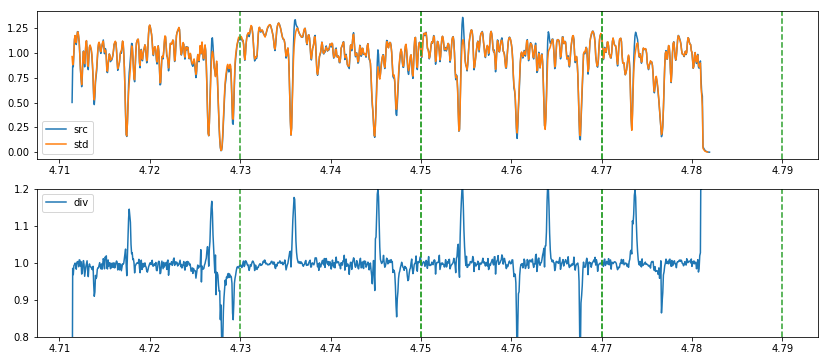

In [5]:
#20101213 This one looks pretty good
srcfile='ABAUR_20101213_1156_spec1d1.fits'
stdfile='HR1620_20101213_0919_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.08, dpix=-0.2, mode='M1')

SNR: 45.48852418341337 81.1805460709587 58.338340625839436
Writing to:  ABAUR_HR1620_20101213_1156_M3_div.fits


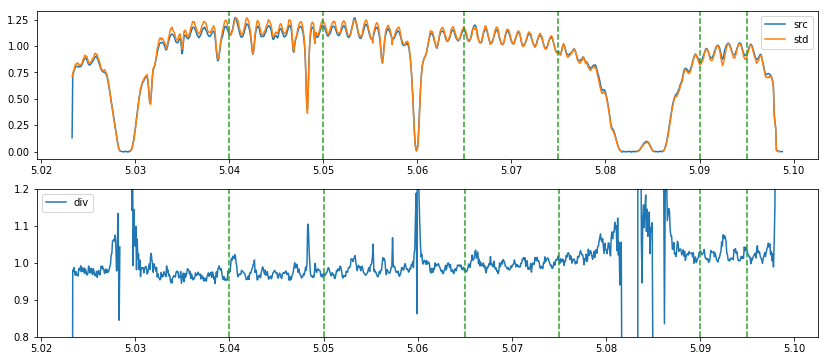

SNR: 19.566989356542482 18.649194217101375 1.3512192583879723
Writing to:  ABAUR_HR1620_20101213_1224_M1_div.fits


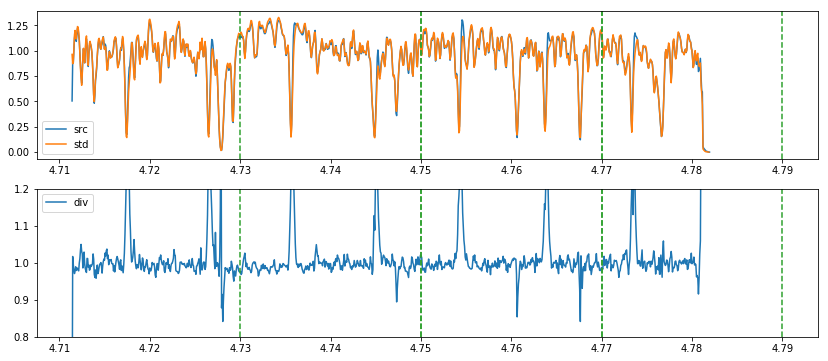

SNR: 25.76045956202249 50.955216528723625 39.17924724678724
Writing to:  ABAUR_HR1620_20101213_1224_M3_div.fits


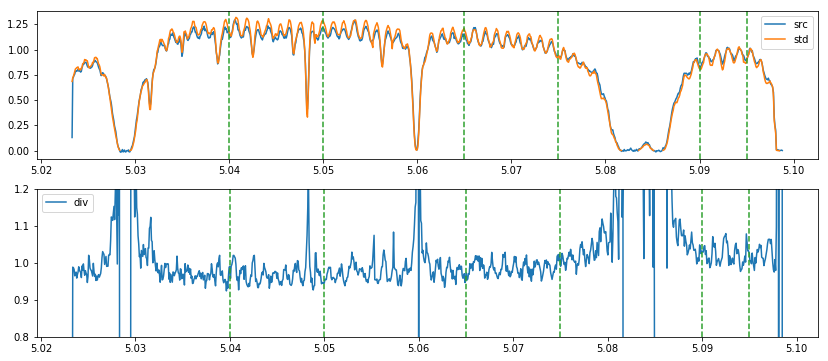

In [6]:
srcfile='ABAUR_20101213_1156_spec1d2.fits' #less than good
stdfile='HR1620_20101213_0919_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.29, dpix=0.0, mode='M3')

srcfile='ABAUR_20101213_1224_spec1d1.fits' #good
stdfile='HR1620_20101213_0926_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.15, dpix=-0.18, mode='M1')

srcfile='ABAUR_20101213_1224_spec1d2.fits' #less than good
stdfile='HR1620_20101213_0926_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.45, dpix=-0.1, mode='M3') #Maybe revisit dpix


**20101214**

In [7]:
datadir='/Users/hanna/Desktop/URSI/data/data/'
filelist=glob.glob(datadir+'*20101214*.fits')
for i,file in enumerate(filelist):
    filename=(file.split('/'))[-1]
    hdulist=fits.open(file)
    #print(filename,hdulist[0].header['AIRMASS'],hdulist[0].header['FILNAME'],hdulist[0].header['WAVA_POS'])

SNR: 11.156924068113444 7.142649006580658 4.110590468011133
Writing to:  ABAUR_HR1620_20101214_1032_M1_div.fits


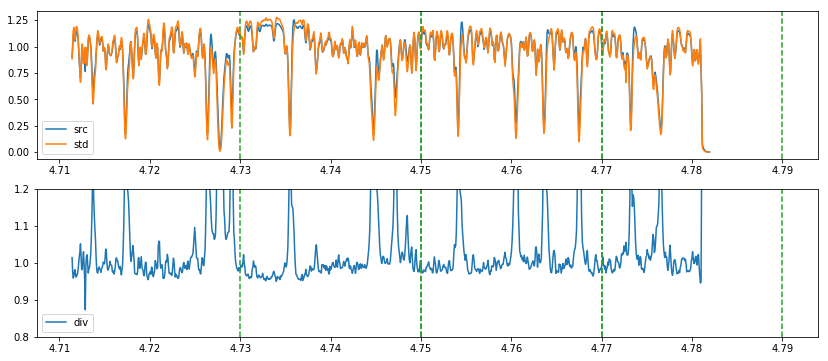

SNR: 31.78114947467909 96.74537427618996 78.41180057101387
Writing to:  ABAUR_HR1620_20101214_1032_M3_div.fits


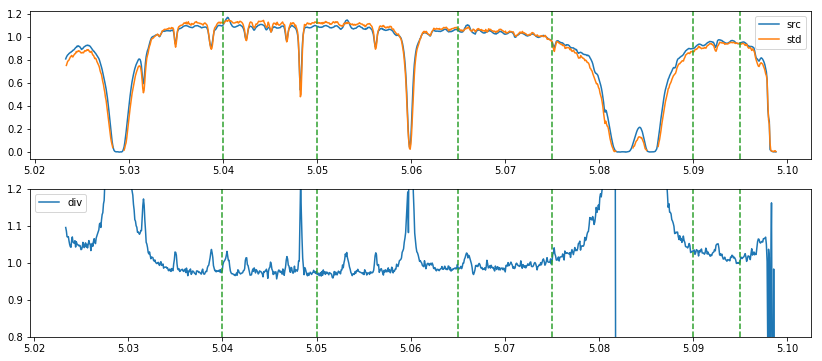

SNR: 23.48371490234603 24.462456498242382 3.2759803458801184
Writing to:  ABAUR_HR383_20101214_1057_M1_div.fits


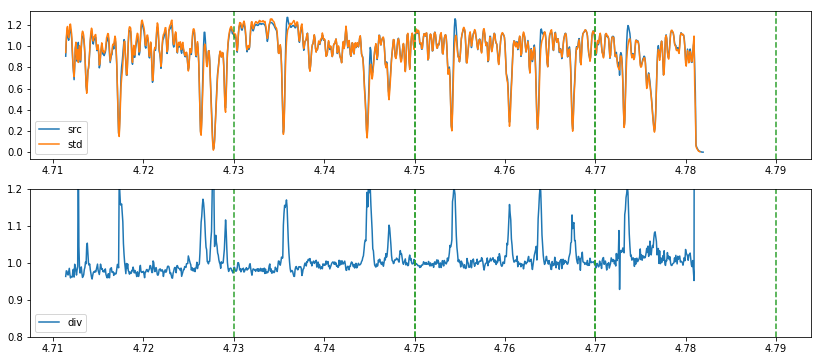

SNR: 57.45714180597827 59.11413377836715 69.85449971534455
Writing to:  ABAUR_HR383_20101214_1057_M3_div.fits


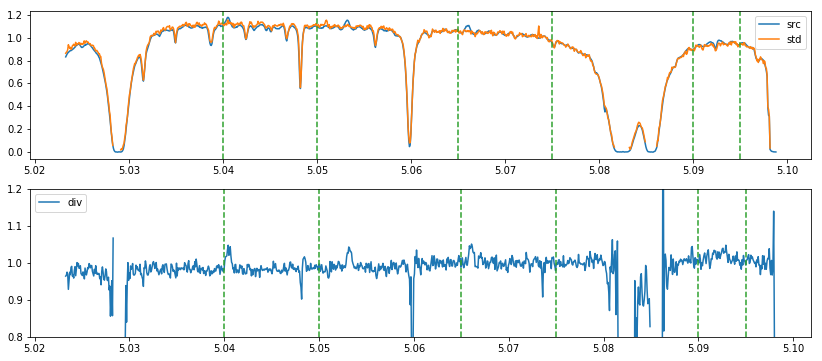

In [8]:
#20101214
srcfile='ABAUR_20101214_1032_spec1d1.fits' #3 peaks is kind of weid is it supposed to look like that?
stdfile='HR1620_20101214_0900_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.18, dpix=-0.0, mode='M1')

srcfile='ABAUR_20101214_1032_spec1d2.fits' #looks much better may want to revisit
stdfile='HR1620_20101214_0900_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=-0.02, dpix=0.3, mode='M3')

srcfile='ABAUR_20101214_1057_spec1d1.fits' #looks okay
stdfile='HR383_20101214_0459_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.07, dpix=-0.4, mode='M1')

srcfile='ABAUR_20101214_1057_spec1d2.fits'#big dips are weird but this might be as good of an emission signal as possible as this point
stdfile='HR383_20101214_0459_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=-0.1, dpix=-0.1, mode='M3')



**20121231**

In [9]:
datadir='/Users/hanna/Desktop/URSI/data/data/'
filelist=glob.glob(datadir+'*20121231*.fits')
for i,file in enumerate(filelist):
    filename=(file.split('/'))[-1]
    hdulist=fits.open(file)
    #print(filename,hdulist[0].header['AIRMASS'],hdulist[0].header['FILNAME'],hdulist[0].header['WAVA_POS'])

SNR: 32.41957012196769 32.22443443984454 14.78362906184635
Writing to:  ABAUR_HR2714_20121231_1051_M1_div.fits


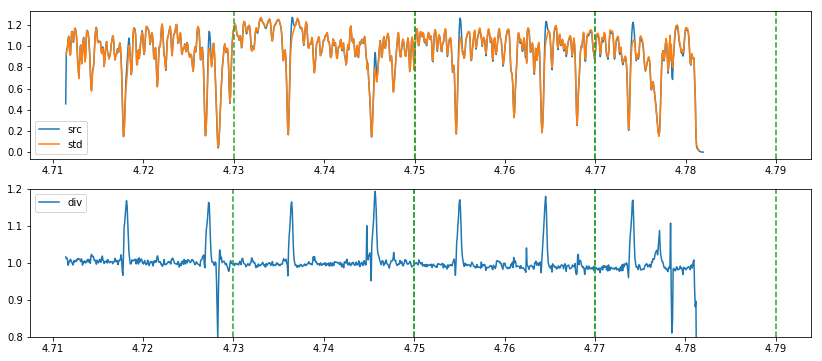

SNR: 77.24914797074241 121.41949008661977 96.33215585015616
Writing to:  ABAUR_HR2714_20121231_1051_M3_div.fits


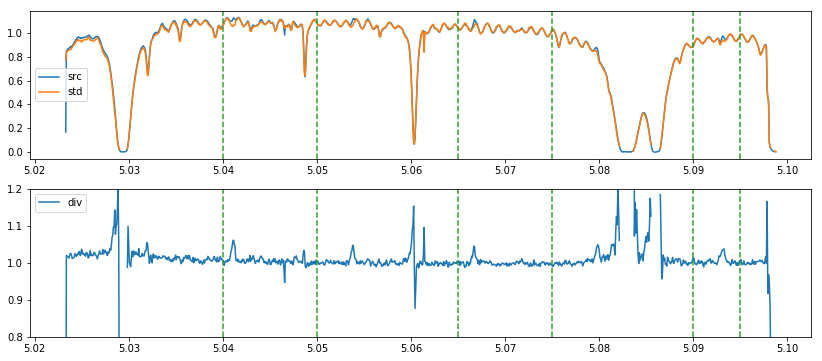

SNR: 30.61056854623614 30.163941254213064 8.883238024754021
Writing to:  ABAUR_HR4494_20121231_1120_M1_div.fits


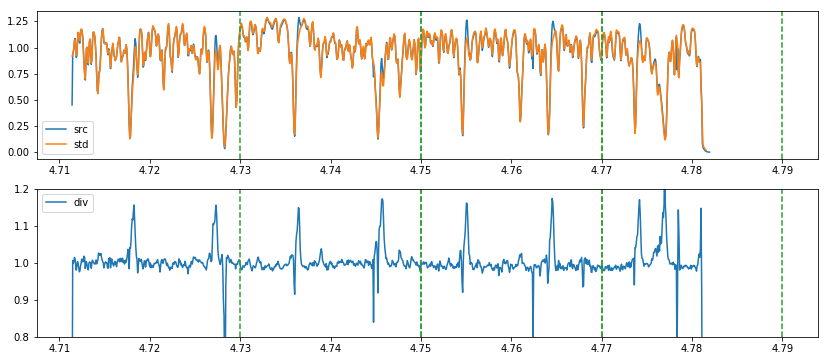

SNR: 82.31108226368809 93.7880426854214 86.70528793160416
Writing to:  ABAUR_HR4494_20121231_1120_M3_div.fits


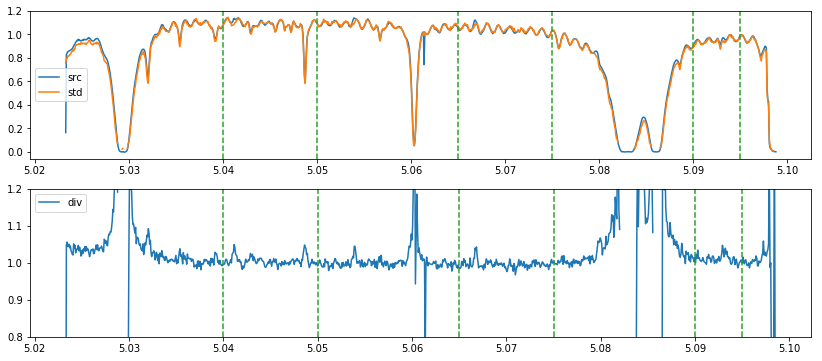

In [10]:
#20121231
srcfile='ABAUR_20121231_1051_spec1d1.fits' #starting to look much better
stdfile='HR2714_20121231_1330_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=-0.1, dpix=0.08, mode='M1')

srcfile='ABAUR_20121231_1051_spec1d2.fits' #looks better, less than great.
stdfile='HR2714_20121231_1330_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=-0.1, dpix=-0.1, mode='M3')

srcfile='ABAUR_20121231_1120_spec1d1.fits' #emission much clearer maybe revisit dpix?
stdfile='HR4494_20121231_1456_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=-0.16, dpix=-0.11, mode='M1')

srcfile='ABAUR_20121231_1120_spec1d2.fits' #definitly much better with dtau between -.2 and -.3. Might want to mess around with that range more
stdfile='HR4494_20121231_1456_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=-0.1, dpix=-0.1, mode='M3')



**20130101**

In [11]:
datadir='/Users/hanna/Desktop/URSI/data/data/'
filelist=glob.glob(datadir+'*20130101*.fits')
for i,file in enumerate(filelist):
    filename=(file.split('/'))[-1]
    hdulist=fits.open(file)
    #print(filename,hdulist[0].header['AIRMASS'],hdulist[0].header['FILNAME'],hdulist[0].header['WAVA_POS'])

SNR: 31.59566043724616 137.20863901946618 16.78423691463569
Writing to:  ABAUR_HR1620_20130101_1056_M0_div.fits


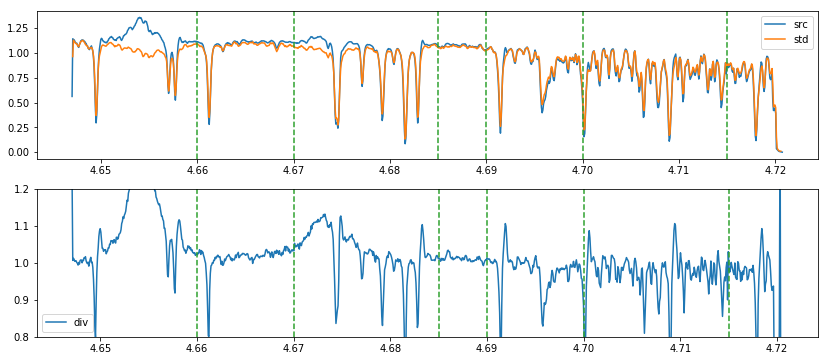

SNR: 58.64993768218944 65.60808642155543 103.56398074204229
Writing to:  ABAUR_HR1620_20130101_1056_M2_div.fits


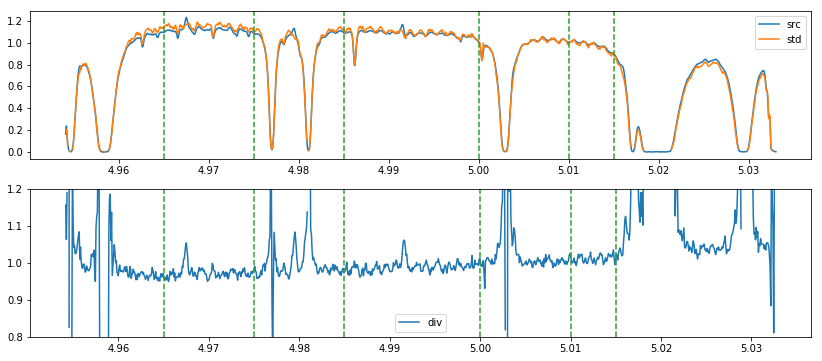

SNR: 35.829899906397436 144.84650669767265 18.809817451040374
Writing to:  ABAUR_HR2714_20130101_1122_M0_div.fits


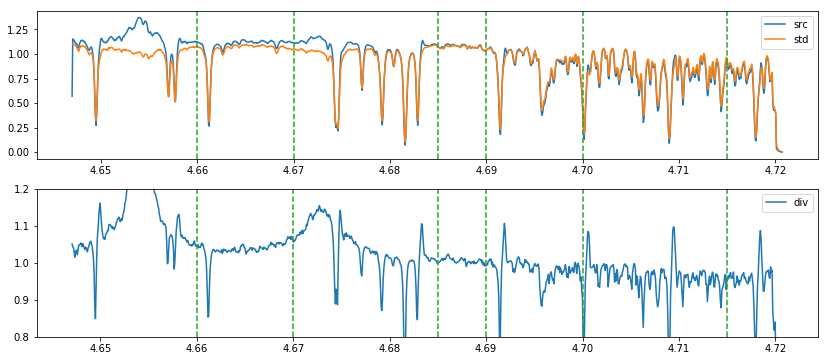

SNR: 58.75422756998767 42.49733096875341 67.71552043985814
Writing to:  ABAUR_HR2714_20130101_1122_M2_div.fits


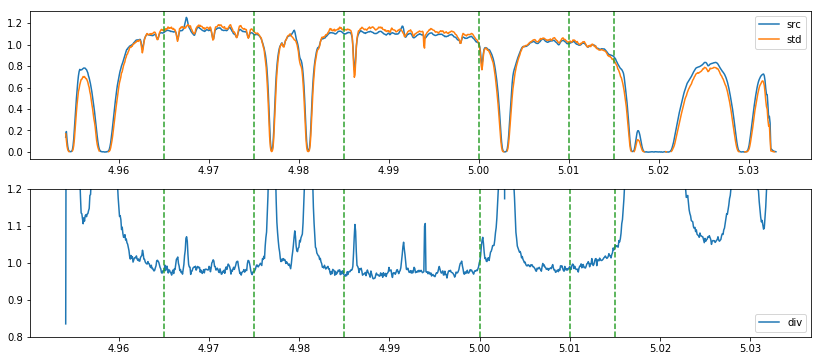

In [12]:
#20130101
srcfile='ABAUR_20130101_1056_spec1d1.fits' #there is a very large peak I cannot resolve. Might want to mess around with more
stdfile='HR1620_20130101_1028_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=-0.08, dpix=0.3, mode='M0')

srcfile='ABAUR_20130101_1056_spec1d2.fits' #was okay at +0.08, revisit
stdfile='HR1620_20130101_1028_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.15, dpix=0.15, mode='M2')

srcfile='ABAUR_20130101_1122_spec1d1.fits' #end very clean, choosing to ignore beginning.
stdfile='HR2714_20130101_1322_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=-0.15, dpix=0.1, mode='M0')

srcfile='ABAUR_20130101_1122_spec1d2.fits' #THIS ONE NEEDS TO BE FIXED 06/29
stdfile='HR2714_20130101_1322_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.3, dpix=-0.1, mode='M2')




**20130103**

In [13]:
datadir='/Users/hanna/Desktop/URSI/data/data/'
filelist=glob.glob(datadir+'*20130103*.fits')
for i,file in enumerate(filelist):
    filename=(file.split('/'))[-1]
    hdulist=fits.open(file)
    #print(filename,hdulist[0].header['AIRMASS'],hdulist[0].header['FILNAME'],hdulist[0].header['WAVA_POS'])

SNR: 10.520864545326688 34.047374932777714 7.4559829404751845
Writing to:  ABAUR_HR1620_20130103_0837_M0_div.fits


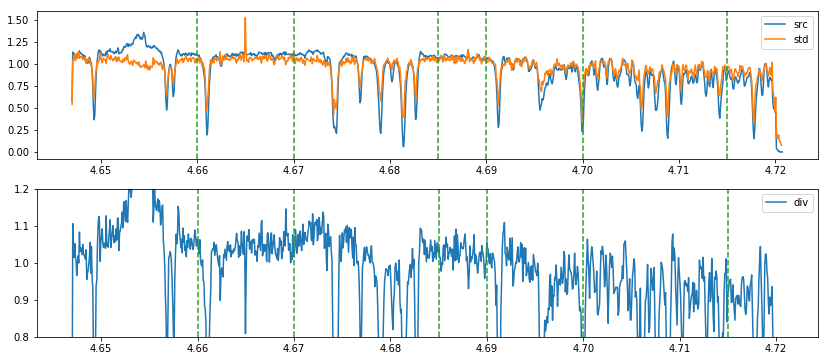

SNR: 24.902778143281736 20.79427361331568 23.69927058681114
Writing to:  ABAUR_HR1620_20130103_0837_M2_div.fits


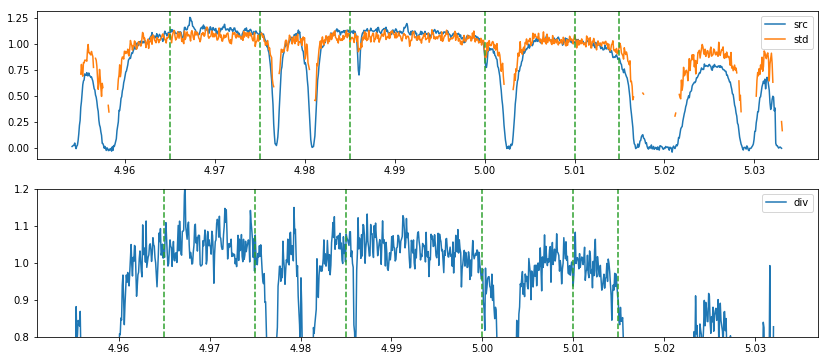

SNR: 16.530658116369334 43.39592265270869 13.161358275425293
Writing to:  ABAUR_HR1620_20130103_0913_M0_div.fits


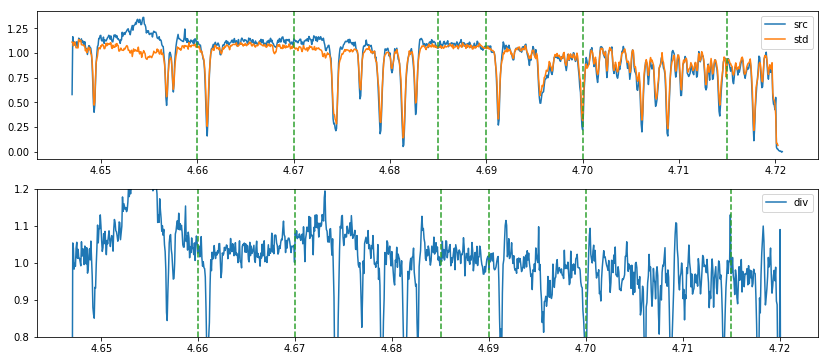

SNR: 21.223631737110853 21.09951502965533 18.997817227752872
Writing to:  ABAUR_HR1620_20130103_0913_M2_div.fits


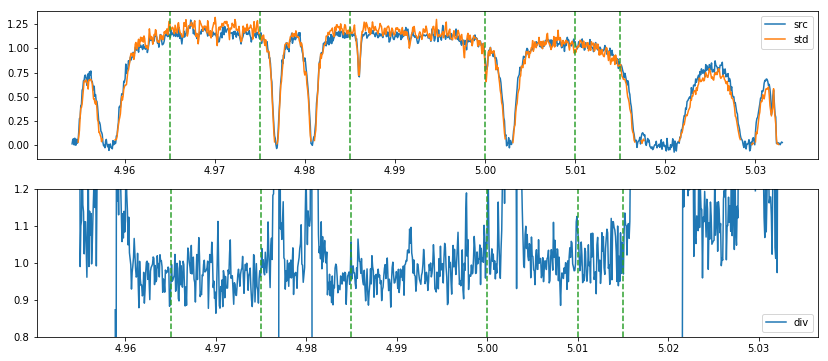

In [14]:
#20130103
srcfile='ABAUR_20130103_0837_spec1d1.fits' #Ask prof. Salyk for advice on this set. This is as good as it is going to be for now.
stdfile='HR1620_20130103_0823_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=-0.5, dpix=0.0, mode='M0')

srcfile='ABAUR_20130103_0837_spec1d2.fits'
stdfile='HR1620_20130103_0823_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=-0.63, dpix=0.5, mode='M2') #come back to this one !!!

srcfile='ABAUR_20130103_0913_spec1d1.fits'
stdfile='HR1620_20130103_0718_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=-0.25, dpix=-0.1, mode='M0')

srcfile='ABAUR_20130103_0913_spec1d2.fits' #THIS ONE ALSO NEEDS TO BE FIXED 06/29
stdfile='HR1620_20130103_0718_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.3, dpix=-0.4, mode='M2')



**20131223**

In [15]:
datadir='/Users/hanna/Desktop/URSI/data/data/'
filelist=glob.glob(datadir+'*20131223*.fits')
for i,file in enumerate(filelist):
    filename=(file.split('/'))[-1]
    hdulist=fits.open(file)
    print(filename,hdulist[0].header['AIRMASS'],hdulist[0].header['FILNAME'],hdulist[0].header['WAVA_POS'])

data\AATAU_20131223_0734_spec1d1.fits 1.05152 M-WIDE-AO 4.646994
data\AATAU_20131223_0734_spec1d2.fits 1.05152 M-WIDE-AO 4.954114
data\AATAU_20131223_0758_spec1d1.fits 1.02458 M-WIDE-AO 4.646994
data\AATAU_20131223_0758_spec1d2.fits 1.02458 M-WIDE-AO 4.954114
data\ABAUR_20131223_1118_spec1d1.fits 1.16299 M-WIDE-AO 4.646994
data\ABAUR_20131223_1118_spec1d2.fits 1.16299 M-WIDE-AO 4.954114
data\ABAUR_20131223_1136_spec1d1.fits 1.21435 M-WIDE-AO 4.646994
data\ABAUR_20131223_1136_spec1d2.fits 1.21435 M-WIDE-AO 4.954114
data\DOTAU_20131223_0559_spec1d1.fits 1.31167 M-WIDE-AO 4.646994
data\DOTAU_20131223_0559_spec1d2.fits 1.31167 M-WIDE-AO 4.954114
data\DOTAU_20131223_0653_spec1d1.fits 1.13377 M-WIDE-AO 4.646994
data\DOTAU_20131223_0653_spec1d2.fits 1.13377 M-WIDE-AO 4.954114
data\DOTAU_20131223_0700_spec1d1.fits 1.11806 M-WIDE-AO 4.646994
data\DOTAU_20131223_0700_spec1d2.fits 1.11806 M-WIDE-AO 4.954114
data\FNTAU_20131223_0827_spec1d1.fits 1.01141 M-WIDE-AO 4.646994
data\FNTAU_20131223_0827_

SNR: 46.78150609996427 75.47535808316412 9.498545669501407
Writing to:  ABAUR_HR1177_20131223_1118_M0_div.fits


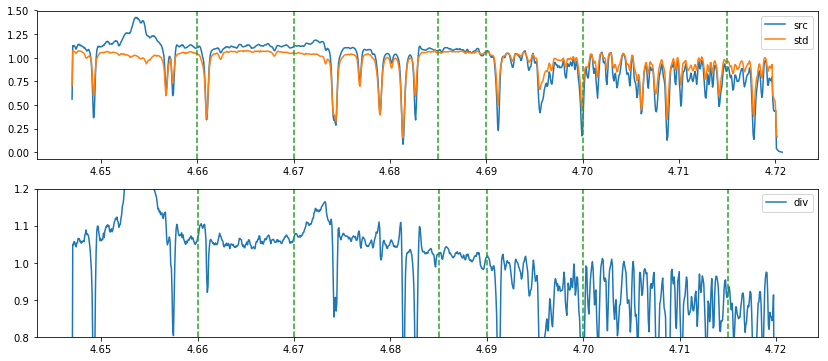

SNR: 49.26039905862064 67.57151073910345 10.63891313581403
Writing to:  ABAUR_HR1177_20131223_1136_M0_div.fits


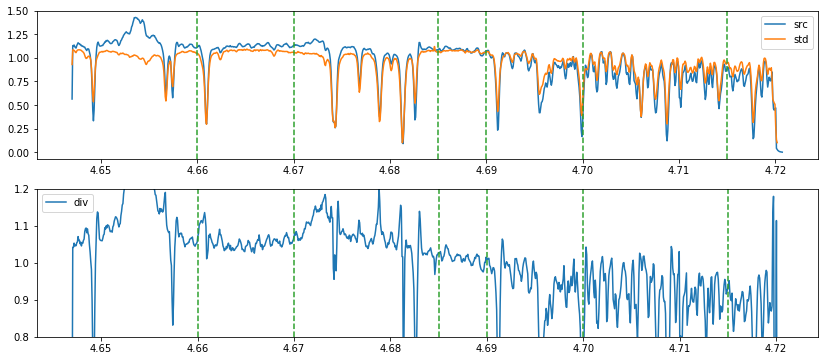

SNR: 47.57728844236735 41.27592034711644 43.57240215619406
Writing to:  ABAUR_HR1177_20131223_1118_M2_div.fits


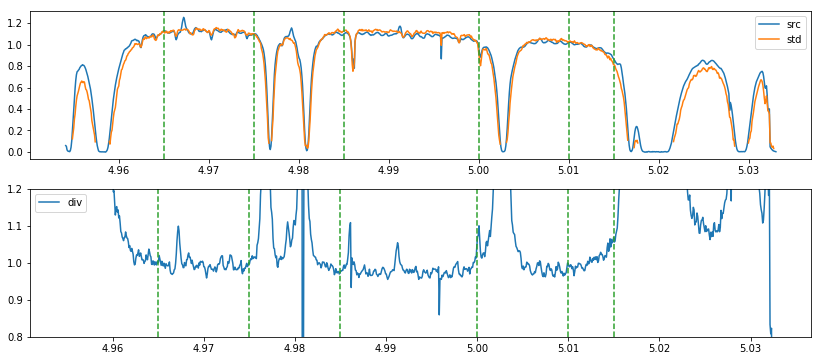

SNR: 41.2482523414629 60.65187013373313 85.61836089203183
Writing to:  ABAUR_HR1177_20131223_1136_M2_div.fits


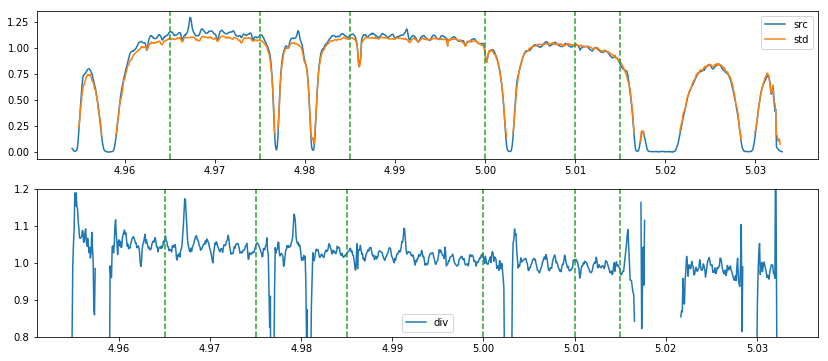

In [16]:
#20131223

srcfile='ABAUR_20131223_1118_spec1d1.fits' #ask for advice on this set too
stdfile='HR1177_20131223_0543_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=-0.5, dpix=-0.3, mode='M0')

srcfile='ABAUR_20131223_1136_spec1d1.fits' #can identify emission peaks but it's fuzzy
stdfile='HR1177_20131223_0543_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=-0.4, dpix=-0.7, mode='M0')


srcfile='ABAUR_20131223_1118_spec1d2.fits' #this one might be good
stdfile='HR1177_20131223_0543_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=-0.3, dpix=-0.2, mode='M2')

srcfile='ABAUR_20131223_1136_spec1d2.fits' #good? compare to second set in this cell
stdfile='HR1177_20131223_0543_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=-0.5, dpix=-0.4, mode='M2')



**20131224**

In [17]:
datadir='/Users/hanna/Desktop/URSI/data/data/'
filelist=glob.glob(datadir+'*20131224*.fits')
for i,file in enumerate(filelist):
    filename=(file.split('/'))[-1]
    hdulist=fits.open(file)
    print(filename,hdulist[0].header['AIRMASS'],hdulist[0].header['FILNAME'],hdulist[0].header['WAVA_POS'])

data\ABAUR_20131224_1124_spec1d1.fits 1.19037 M-WIDE-AO 4.646994
data\ABAUR_20131224_1124_spec1d2.fits 1.19037 M-WIDE-AO 4.954114
data\ABAUR_20131224_1143_spec1d1.fits 1.25083 M-WIDE-AO 4.646994
data\ABAUR_20131224_1143_spec1d2.fits 1.25083 M-WIDE-AO 4.954114
data\DOTAU_20131224_0548_spec1d1.fits 1.3405 M-WIDE-AO 4.646994
data\DOTAU_20131224_0548_spec1d2.fits 1.3405 M-WIDE-AO 4.954114
data\DOTAU_20131224_0614_spec1d1.fits 1.23693 M-WIDE-AO 4.646994
data\DOTAU_20131224_0614_spec1d2.fits 1.23693 M-WIDE-AO 4.954114
data\FNTAU_20131224_0728_spec1d1.fits 1.03791 M-WIDE-AO 4.646994
data\FNTAU_20131224_0728_spec1d2.fits 1.03791 M-WIDE-AO 4.954114
data\FNTAU_20131224_0806_spec1d1.fits 1.01414 M-WIDE-AO 4.646994
data\FNTAU_20131224_0806_spec1d2.fits 1.01414 M-WIDE-AO 4.954114
data\GMAUR_20131224_0903_spec1d1.fits 1.01706 M-WIDE-AO 4.646994
data\GMAUR_20131224_0903_spec1d2.fits 1.01706 M-WIDE-AO 4.954114
data\GMAUR_20131224_0944_spec1d1.fits 1.02901 M-WIDE-AO 4.646994
data\GMAUR_20131224_0944_sp

SNR: 22.41104065748527 94.72221471706239 20.03726230344404
Writing to:  ABAUR_HR1177_20131224_1124_M0_div.fits


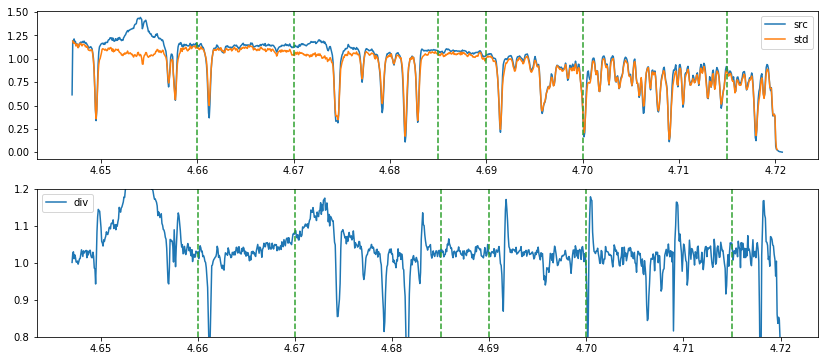

SNR: 24.59289584354323 70.49369921038893 16.36383945863482
Writing to:  ABAUR_HR1620_20131224_1143_M0_div.fits


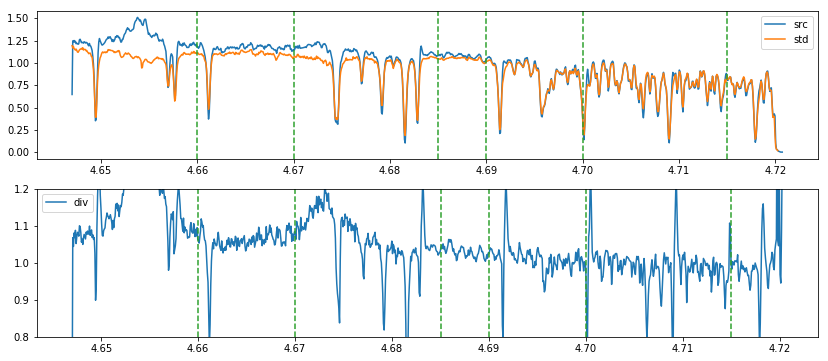

SNR: 49.3698430204165 47.91052280359592 57.07023474885311
Writing to:  ABAUR_HR1177_20131224_1124_M2_div.fits


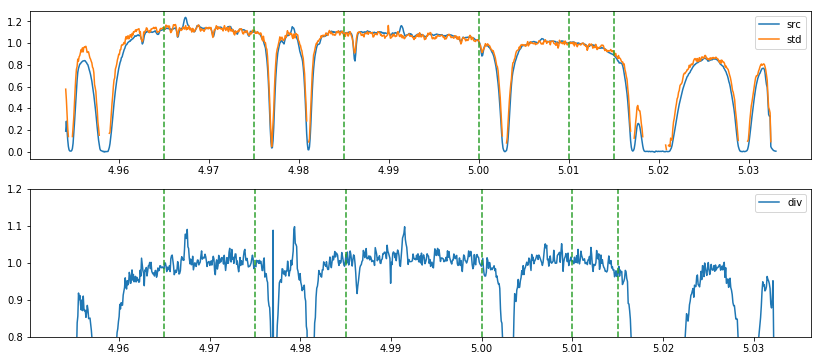

SNR: 36.93694871541254 48.55385683807359 73.69974135707281
Writing to:  ABAUR_HR1620_20131224_1143_M2_div.fits


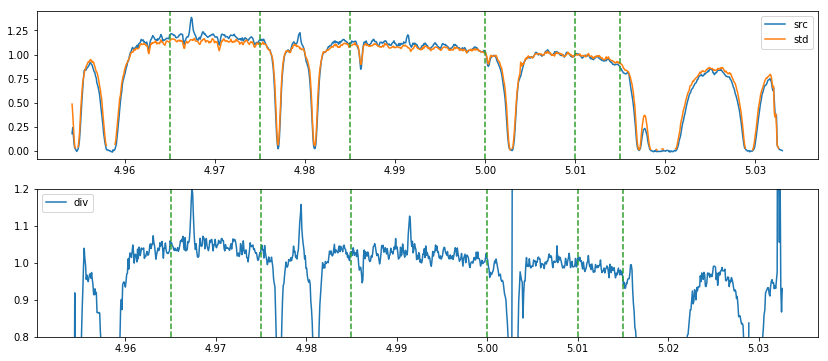

In [18]:
#20131224

srcfile='ABAUR_20131224_1124_spec1d1.fits'
stdfile='HR1177_20131224_0533_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=-0.09, dpix=0.2, mode='M0')

srcfile='ABAUR_20131224_1143_spec1d1.fits'
stdfile='HR1620_20131224_0638_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=-0.09, dpix=-0.8, mode='M0')

srcfile='ABAUR_20131224_1124_spec1d2.fits'
stdfile='HR1177_20131224_0533_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=-0.15, dpix=-0.1, mode='M2')


srcfile='ABAUR_20131224_1143_spec1d2.fits'
stdfile='HR1620_20131224_0638_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=-0.05, dpix=-0.5, mode='M2')



**Combining Spectra Together**

In [19]:
ABAUR_20101213_files = ['ABAUR_HR1620_20101213_1156_M1_div.fits', 'ABAUR_HR1620_20101213_1156_M3_div.fits','ABAUR_HR1620_20101213_1224_M1_div.fits', 'ABAUR_HR1620_20101213_1224_M3_div.fits','ABAUR_HR1620_20101214_1032_M1_div.fits', 'ABAUR_HR1620_20101214_1032_M3_div.fits', 'ABAUR_HR383_20101214_1057_M1_div.fits', 'ABAUR_HR383_20101214_1057_M3_div.fits']
ABAUR_20121231_files = ['ABAUR_HR1620_20130103_0913_M0_div.fits','ABAUR_HR1620_20130103_0837_M0_div.fits', 'ABAUR_HR2714_20130101_1122_M0_div.fits','ABAUR_HR1620_20130101_1056_M0_div.fits','ABAUR_HR2714_20121231_1051_M1_div.fits', 'ABAUR_HR2714_20121231_1051_M3_div.fits', 'ABAUR_HR4494_20121231_1120_M1_div.fits', 'ABAUR_HR4494_20121231_1120_M3_div.fits', 'ABAUR_HR1620_20130101_1056_M2_div.fits','ABAUR_HR2714_20130101_1122_M2_div.fits','ABAUR_HR1620_20130103_0837_M2_div.fits','ABAUR_HR1620_20130103_0913_M2_div.fits']
ABAUR_20131223_files = ['ABAUR_HR1177_20131223_1118_M2_div.fits','ABAUR_HR1177_20131223_1136_M2_div.fits','ABAUR_HR1177_20131224_1124_M0_div.fits','ABAUR_HR1177_20131224_1124_M2_div.fits','ABAUR_HR1620_20131224_1143_M0_div.fits','ABAUR_HR1620_20131224_1143_M2_div.fits', 'ABAUR_HR1177_20131223_1136_M0_div.fits','ABAUR_HR1177_20131223_1118_M0_div.fits',]

In [20]:
(wave,div)=gluespec('/Users/hanna/Desktop/URSI/',ABAUR_20101213_files)
(wave,div)=gluespec('/Users/hanna/Desktop/URSI/',ABAUR_20121231_files)
(wave,div)=gluespec('/Users/hanna/Desktop/URSI/',ABAUR_20131223_files)

Writing to:  ABAUR_20101213_glue.fits
Writing to:  ABAUR_20130103_glue.fits
Writing to:  ABAUR_20131223_glue.fits


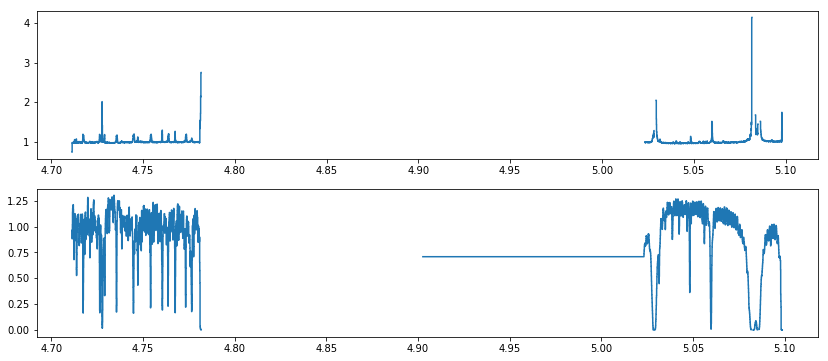

In [21]:
hdulist=fits.open('/Users/hanna/Desktop/URSI/ABAUR_20101213_glue.fits')
data=hdulist[1].data
fig=plt.figure(figsize=(14,6))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)

ax1.plot(data['wave'],data['div'],linestyle='steps-mid')
ax2.plot(data['wave'],data['std'],linestyle='steps-mid')

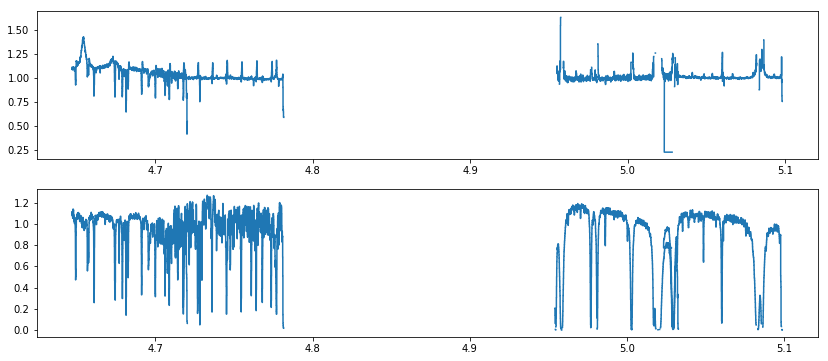

In [22]:
hdulist=fits.open('/Users/hanna/Desktop/URSI/ABAUR_20130103_glue.fits')
data=hdulist[1].data
fig=plt.figure(figsize=(14,6))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)

ax1.plot(data['wave'],data['div'],linestyle='steps-mid')
ax2.plot(data['wave'],data['std'],linestyle='steps-mid')

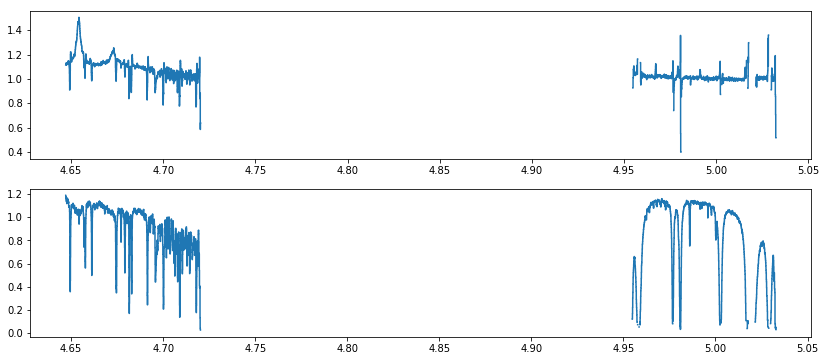

In [23]:
hdulist=fits.open('/Users/hanna/Desktop/URSI/ABAUR_20131223_glue.fits')
data=hdulist[1].data
fig=plt.figure(figsize=(14,6))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)

ax1.plot(data['wave'],data['div'],linestyle='steps-mid')
ax2.plot(data['wave'],data['std'],linestyle='steps-mid')